In [768]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
%matplotlib inline
import time
from collections import Counter
from sklearn import metrics

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

## first pass pre made BERT embeddings with continuous variable
- made up data

In [31]:
subj = torch.rand(160,768).numpy()
medhx = torch.rand(160,768).numpy()
cont = torch.rand(160,10).numpy()
labels = torch.randint(0,3,(160,)).numpy()

In [33]:
subj.shape, medhx.shape, cont.shape, labels.shape

((160, 768), (160, 768), (160, 10), (160,))

In [34]:
train_subj, validation_subj = train_test_split(subj, random_state = 42, test_size=0.1)
train_medhx, validation_medhx = train_test_split(medhx, random_state = 42, test_size=0.1)
train_cont, validation_cont = train_test_split(cont, random_state = 42, test_size=0.1)
train_labels, validation_labels = train_test_split(labels, random_state = 42, test_size=0.1)

In [35]:
train_subj = torch.tensor(train_subj)
validation_subj = torch.tensor(validation_subj)
train_medhx = torch.tensor(train_medhx)
validation_medhx = torch.tensor(validation_medhx)
train_cont = torch.tensor(train_cont)
validation_cont = torch.tensor(validation_cont)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

In [36]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 4

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_subj, train_medhx, train_cont,train_labels)
trainloader = DataLoader(train_data, batch_size=batch_size)

valid_data = TensorDataset(validation_subj, validation_medhx, validation_cont, validation_labels)
validloader = DataLoader(valid_data, batch_size=batch_size)

In [37]:
#hyperparameters
lr = 1
epochs = 10
loss_func = nn.CrossEntropyLoss()

In [38]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        
        self.linear_subjective = nn.Linear(768,10)  
        self.linear_medhx = nn.Linear(768, 10)
        self.linear_combined = nn.Linear(30, 10)
        self.out = nn.Linear(10,4)

    def forward(self, subj,medhx,cont):
        nlp1 = F.relu(self.linear_subjective(subj))
        nlp2 = F.relu(self.linear_medhx(medhx))
        combined = torch.cat((nlp1,nlp2,cont), axis = 1)
        x = F.relu(self.linear_combined(combined))
        x = self.out(x)
        return x



In [39]:
net = Net()
net

Net(
  (linear_subjective): Linear(in_features=768, out_features=10, bias=True)
  (linear_medhx): Linear(in_features=768, out_features=10, bias=True)
  (linear_combined): Linear(in_features=30, out_features=10, bias=True)
  (out): Linear(in_features=10, out_features=4, bias=True)
)

### testing the forward method

In [40]:
x1,x2,x3,x4 = next(iter(trainloader))

In [41]:
net(x1,x2,x3)

tensor([[-0.1384,  0.2051, -0.3294,  0.1121],
        [-0.1240,  0.2034, -0.3558,  0.1069],
        [-0.1337,  0.2237, -0.3588,  0.0350],
        [-0.1064,  0.2089, -0.3560,  0.1055]], grad_fn=<AddmmBackward>)

### trying the training loop

In [42]:
def train_model(model):
    optimizer = Adam(model.parameters(), lr = lr)
    running_loss = []
    for epoch_num in range(epochs):
        model.train()
        train_loss = 0
        for step_num, batch_data in enumerate(trainloader):
        
            cont_var, subj_notes, medhx, labels = tuple(t.to(device) for t in batch_data)
        
            optimizer.zero_grad()
        
            logits = model(cont_var, subj_notes, medhx)#, cat_var)
        
            batch_loss = loss_func(logits, labels)
        
            train_loss += batch_loss.item()
        
            batch_loss.backward()
        

            clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        
            optimizer.step()
        
            if step_num %12 == 0:
                print('Epoch: ', epoch_num + 1)
                print("\r" + "{0}/{1} loss: {2} ".format(step_num, len(train_data) / batch_size, train_loss / (step_num + 1)))
            
        running_loss.append(train_loss)

    return running_loss

In [43]:
cum_loss = train_model(net)

Epoch:  1
0/36.0 loss: 1.4609160423278809 
Epoch:  1
12/36.0 loss: 6626.937793273192 
Epoch:  1
24/36.0 loss: 3446.6568507003785 
Epoch:  2
0/36.0 loss: 1.6175388097763062 
Epoch:  2
12/36.0 loss: 1.2158456215491662 
Epoch:  2
24/36.0 loss: 1.1831336450576782 
Epoch:  3
0/36.0 loss: 1.5438588857650757 
Epoch:  3
12/36.0 loss: 1.1842343623821552 
Epoch:  3
24/36.0 loss: 1.159710364341736 
Epoch:  4
0/36.0 loss: 1.6018681526184082 
Epoch:  4
12/36.0 loss: 1.1966940256265493 
Epoch:  4
24/36.0 loss: 1.166122121810913 
Epoch:  5
0/36.0 loss: 1.6093086004257202 
Epoch:  5
12/36.0 loss: 1.2002241978278527 
Epoch:  5
24/36.0 loss: 1.1681951045989991 
Epoch:  6
0/36.0 loss: 1.6111395359039307 
Epoch:  6
12/36.0 loss: 1.2017108843876765 
Epoch:  6
24/36.0 loss: 1.1691481161117554 
Epoch:  7
0/36.0 loss: 1.61270010471344 
Epoch:  7
12/36.0 loss: 1.2026233948194063 
Epoch:  7
24/36.0 loss: 1.1697545337677002 
Epoch:  8
0/36.0 loss: 1.6136481761932373 
Epoch:  8
12/36.0 loss: 1.203214663725633 
Ep

In [44]:
cum_loss

[86183.85667216778,
 44.014511823654175,
 43.58671426773071,
 43.78844529390335,
 43.84966313838959,
 43.878470838069916,
 43.89542007446289,
 43.90597438812256,
 43.91312235593796,
 43.91829025745392]

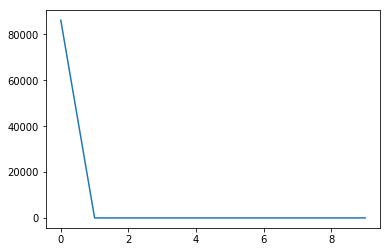

In [45]:
plt.plot(cum_loss)

## now we are going to make the model more complex and add embedding
- still made up data

In [397]:
subj = torch.rand(160,768).numpy()
medhx = torch.rand(160,768).numpy()
cont = torch.rand(160,10).numpy()
labels = torch.randint(0,3,(160,)).numpy()

In [398]:
cats = np.random.randint(1, 30, size=(160))

In [399]:
len(set(cats))

29

In [400]:
#not sure which the best method for embedding filters is but likley # 2
embedding_size = min(50, (len(set(cats))// 2) +1)
embedding_size2 = min(600, round(1.6 * len(set(cats))**0.56))
embedding_size, embedding_size2

(15, 11)

In [401]:
train_subj, validation_subj = train_test_split(subj, random_state = 42, test_size=0.1)
train_medhx, validation_medhx = train_test_split(medhx, random_state = 42, test_size=0.1)
train_cont, validation_cont = train_test_split(cont, random_state = 42, test_size=0.1)
train_cats, validation_cats = train_test_split(cats, random_state = 42, test_size=0.1)
train_labels, validation_labels = train_test_split(labels, random_state = 42, test_size=0.1)

In [402]:
train_subj = torch.tensor(train_subj)
validation_subj = torch.tensor(validation_subj)
train_medhx = torch.tensor(train_medhx)
validation_medhx = torch.tensor(validation_medhx)
train_cont = torch.tensor(train_cont)
validation_cont = torch.tensor(validation_cont)
train_cats = torch.tensor(train_cats)
validation_cats = torch.tensor(validation_cats)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

In [403]:
# Select a batch size for training. For fine-tuning BERT on a specific task, the authors recommend a batch size of 16 or 32
batch_size = 4

# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory

train_data = TensorDataset(train_subj, train_medhx, train_cont,train_cats,train_labels)
trainloader = DataLoader(train_data, batch_size=batch_size)

valid_data = TensorDataset(validation_subj, validation_medhx, validation_cont, validation_cats, validation_labels)
validloader = DataLoader(valid_data, batch_size=batch_size)

In [404]:
class Net1(nn.Module):
    def __init__(self):
        super(Net1, self).__init__()
        
        self.linear_subjective = nn.Linear(768,10)  
        self.linear_medhx = nn.Linear(768, 10)
        self.embedding = nn.Embedding(len(set(cats))+1, 30)
        self.linear_cat = nn.Linear(30,10)
        self.linear_combined = nn.Linear(40, 10)
        self.out = nn.Linear(10,4)

    def forward(self, subj,medhx,cont,cat_var):
        nlp1 = F.relu(self.linear_subjective(subj))
        nlp2 = F.relu(self.linear_medhx(medhx))
        embeds = self.embedding(cat_var)
        cats = F.relu(self.linear_cat(embeds))
        combined = torch.cat((nlp1,nlp2,cont,cats), axis = 1)
        x = F.relu(self.linear_combined(combined))
        x = self.out(x)
        return x



In [405]:
def train_model2(model, lr = 1e-3, epochs = 10, loss_func = nn.CrossEntropyLoss()):
    optimizer = Adam(model.parameters(), lr = lr)
    running_loss = []
    for epoch_num in range(epochs):
        model.train()
        train_loss = 0
        for step_num, batch_data in enumerate(trainloader):
        
            cont_var, subj_notes, medhx, cat_var, labels = tuple(t.to(device) for t in batch_data)
        
            optimizer.zero_grad()
        
            logits = model(cont_var, subj_notes, medhx, cat_var)
        
            batch_loss = loss_func(logits, labels)
        
            train_loss += batch_loss.item()
        
            batch_loss.backward()
        

            clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        
            optimizer.step()
        
            print('Epoch: ', epoch_num + 1)
            print("\r" + "{0}/{1} loss: {2} ".format(step_num, len(train_data) / batch_size, train_loss / (step_num + 1)))
            
        running_loss.append(train_loss)

    return running_loss

In [406]:
net = Net1()
print(net)

Net1(
  (linear_subjective): Linear(in_features=768, out_features=10, bias=True)
  (linear_medhx): Linear(in_features=768, out_features=10, bias=True)
  (embedding): Embedding(30, 30)
  (linear_cat): Linear(in_features=30, out_features=10, bias=True)
  (linear_combined): Linear(in_features=40, out_features=10, bias=True)
  (out): Linear(in_features=10, out_features=4, bias=True)
)


In [407]:
x1,x2,x3,x4,x5 = next(iter(trainloader))

In [408]:
net(x1,x2,x3,x4)

tensor([[ 0.0392, -0.2653, -0.2816, -0.0602],
        [ 0.0389, -0.3038, -0.2784, -0.0424],
        [ 0.1807, -0.2866, -0.2834, -0.0349],
        [ 0.0880, -0.2504, -0.2093, -0.0058]], grad_fn=<AddmmBackward>)

In [57]:
cum_loss = train_model2(net)

Epoch:  1
0/36.0 loss: 1.4564157724380493 
Epoch:  1
12/36.0 loss: 1.3908660778632531 
Epoch:  1
24/36.0 loss: 1.3096880102157593 
Epoch:  2
0/36.0 loss: 1.1334772109985352 
Epoch:  2
12/36.0 loss: 1.2425980797180762 
Epoch:  2
24/36.0 loss: 1.1831288576126098 
Epoch:  3
0/36.0 loss: 1.0782979726791382 
Epoch:  3
12/36.0 loss: 1.1369681174938495 
Epoch:  3
24/36.0 loss: 1.1143255043029785 
Epoch:  4
0/36.0 loss: 1.0798842906951904 
Epoch:  4
12/36.0 loss: 1.089571659381573 
Epoch:  4
24/36.0 loss: 1.0901463556289672 
Epoch:  5
0/36.0 loss: 1.0853729248046875 
Epoch:  5
12/36.0 loss: 1.0698626316510713 
Epoch:  5
24/36.0 loss: 1.0787011671066284 
Epoch:  6
0/36.0 loss: 1.0809965133666992 
Epoch:  6
12/36.0 loss: 1.0579146788670466 
Epoch:  6
24/36.0 loss: 1.070279860496521 
Epoch:  7
0/36.0 loss: 1.0749640464782715 
Epoch:  7
12/36.0 loss: 1.0462983617415795 
Epoch:  7
24/36.0 loss: 1.0594910216331481 
Epoch:  8
0/36.0 loss: 1.055727481842041 
Epoch:  8
12/36.0 loss: 1.032783554150508 


## next I'm going to make a pipeline for converting a list of categories into embedded classes
### and turn those into model layers

In [58]:
animals = ['manatee', 'dog', 'giraffe', 'narwhal', 'cat', 'elephant', 'mouse', 'dingo', 'wombat', 'skunk']
cat_data = [[animal]* 16 for animal in animals]
cat_data = [item for sublist in cat_data for item in sublist]
random.shuffle(cat_data)

In [59]:
animal_to_num = {animal:i for i,animal in enumerate(list(set(cat_data)))}
num_to_animal = {i:animal for animal, i in enumerate(list(set(cat_data)))}

In [592]:
#this is going to be my fake categorical animal data
numerical_cat_data = [animal_to_num[item] for item in cat_data]

In [61]:
len(numerical_cat_data), set(numerical_cat_data), len(set(numerical_cat_data))

(160, {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}, 10)

### copied tabular learner code from fast.ai
- trying to figure out how to build the model construction pipeline that I want

In [ ]:
class TabularModel(nn.Module):
    "Basic model for tabular data."
    def __init__(self, emb_szs:ListSizes, n_cont:int, out_sz:int, layers:Collection[int], ps:Collection[float]=None,
                 emb_drop:float=0., y_range:OptRange=None, use_bn:bool=True, bn_final:bool=False):
        super().__init__()
        ps = ifnone(ps, [0]*len(layers))
        ps = listify(ps, layers)
        self.embeds = nn.ModuleList([embedding(ni, nf) for ni,nf in emb_szs])
        self.emb_drop = nn.Dropout(emb_drop)
        self.bn_cont = nn.BatchNorm1d(n_cont)
        n_emb = sum(e.embedding_dim for e in self.embeds)
        self.n_emb,self.n_cont,self.y_range = n_emb,n_cont,y_range
        sizes = self.get_sizes(layers, out_sz)
        actns = [nn.ReLU(inplace=True) for _ in range(len(sizes)-2)] + [None]
        layers = []
        for i,(n_in,n_out,dp,act) in enumerate(zip(sizes[:-1],sizes[1:],[0.]+ps,actns)):
            layers += bn_drop_lin(n_in, n_out, bn=use_bn and i!=0, p=dp, actn=act)
        if bn_final: layers.append(nn.BatchNorm1d(sizes[-1]))
        self.layers = nn.Sequential(*layers)

    def get_sizes(self, layers, out_sz):
        return [self.n_emb + self.n_cont] + layers + [out_sz]

    def forward(self, x_cat:Tensor, x_cont:Tensor) -> Tensor:
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embeds)]
            x = torch.cat(x, 1)
            x = self.emb_drop(x)
        if self.n_cont != 0:
            x_cont = self.bn_cont(x_cont)
            x = torch.cat([x, x_cont], 1) if self.n_emb != 0 else x_cont
        x = self.layers(x)
        if self.y_range is not None:
            x = (self.y_range[1]-self.y_range[0]) * torch.sigmoid(x) + self.y_range[0]
        return x

In [ ]:
emb_szs = [(30,30), (20,20), (400,50)]
embed_layers = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
embed_layers

In [ ]:
embed_layers = [nn.Embedding(ni, nf) for ni,nf in emb_szs]
embed_layers

In [ ]:
n_emb = sum(e.embedding_dim for e in embed_layers); n_emb

In [ ]:
layers=[200,100]
n_cont = 3

In [ ]:
def get_sizes(layers, out_sz):
    return [n_emb + n_cont] + layers + [out_sz]

In [ ]:
sizes = get_sizes(layers, 4); sizes

In [ ]:
actns = [nn.ReLU(inplace=True) for _ in range(len(sizes)-2)] + [None]; actns

In [ ]:
def forward(self, x_cat:Tensor, x_cont:Tensor) -> Tensor:
        if self.n_emb != 0:
            x = [e(x_cat[:,i]) for i,e in enumerate(self.embeds)]
            x = torch.cat(x, 1)
            x = self.emb_drop(x)
        if self.n_cont != 0:
            x_cont = self.bn_cont(x_cont)
            x = torch.cat([x, x_cont], 1) if self.n_emb != 0 else x_cont
        x = self.layers(x)
        if self.y_range is not None:
            x = (self.y_range[1]-self.y_range[0]) * torch.sigmoid(x) + self.y_range[0]
        return x

In [ ]:
cats = np.random.randint(0, 29, size=(160))

In [ ]:
cats.shape, len(set(cats))

### fast.ai code code deconstructed above
#### using that style to create my model

In [593]:
subj = torch.rand(160,768).numpy()
medhx = torch.rand(160,768).numpy()
cont = torch.rand(160,10).numpy()
labels = torch.randint(0,3,(160,)).numpy()

In [612]:
subj.dtype, medhx.dtype

(dtype('float32'), dtype('float32'))

In [594]:
cats = np.random.randint(0, 29, size=(160))

In [595]:
#so lets say I have 2 columns of categorical data:
cat1 = numerical_cat_data #from the "animal data" I created above
cat2 = cats #the original random number data set

In [596]:
type(cats)

numpy.ndarray

In [597]:
cat_list = [cat1,cat2]

In [598]:
class_lengths = [len(set(cat)) for cat in cat_list]
class_lengths

[10, 29]

In [599]:
#this is an array the categorical data
cats_array = np.vstack([np.array(cat) for cat in cat_list]).transpose(); cats_array.shape

#this is a code I used during dev to go straight to a tensor
#torch_cats = torch.tensor(np.vstack([np.array(cat) for cat in cat_list])).t(); cat3.shape

(160, 2)

In [600]:
cats_array[:,0]

array([1, 9, 0, 0, 5, 2, 7, 9, 9, 4, 2, 6, 5, 3, 3, 4, 5, 9, 3, 0, 7, 6,
       9, 1, 2, 8, 6, 2, 9, 6, 1, 1, 3, 2, 3, 5, 4, 9, 2, 3, 4, 8, 6, 7,
       7, 3, 7, 6, 7, 9, 2, 0, 5, 7, 3, 3, 0, 4, 6, 7, 1, 5, 7, 7, 5, 3,
       1, 0, 3, 4, 9, 8, 4, 6, 4, 3, 9, 2, 9, 2, 8, 8, 5, 4, 1, 5, 3, 8,
       8, 6, 5, 3, 1, 1, 5, 7, 8, 0, 8, 5, 0, 1, 2, 4, 2, 5, 8, 4, 0, 0,
       0, 3, 1, 7, 8, 5, 3, 6, 4, 0, 2, 6, 1, 8, 1, 9, 2, 8, 8, 6, 4, 4,
       0, 6, 9, 8, 2, 1, 2, 6, 1, 8, 9, 7, 9, 6, 4, 0, 7, 9, 7, 0, 1, 2,
       6, 5, 0, 5, 7, 4])

In [601]:
cats_array[:,1]

array([ 5,  2, 18,  5, 12, 20,  1, 14, 20, 16, 11, 24,  2,  0, 28, 10, 18,
       16, 27,  3, 12,  0, 18, 16, 19,  6, 27,  2, 16, 28, 12, 14, 17, 13,
        3,  8, 10,  3, 21, 21, 24, 15, 27,  6,  3,  1,  4, 11,  2, 11, 22,
       11, 12,  2, 17,  0,  2, 14,  2,  1, 21, 28,  4, 27, 12,  3, 28, 27,
       13, 23,  2, 21, 23,  3, 25, 21,  2, 10, 14, 13,  2, 23, 28,  2, 18,
        2, 26,  7, 26,  9, 19,  7, 10, 21, 19, 18, 17,  7, 20,  3, 22,  5,
       22, 24, 17,  7,  5, 11, 18, 15,  7, 13,  4,  4, 16,  3, 26, 24,  1,
       14, 25, 19, 25, 20, 11, 19, 25,  2,  8, 21, 20,  1, 28, 18, 17, 25,
       28,  2,  4, 20, 20, 20, 12, 10, 12,  7, 24, 10, 13, 25, 10,  8,  5,
       12,  4, 14, 26, 23, 26, 15])

In [602]:
#creating a set of embedding sizes for each categorical variable
emb_szs = [(length, min(600, round(1.6 * length **0.56))) for length in class_lengths]
emb_szs

[(10, 6), (29, 11)]

In [603]:
class Net2(nn.Module):
    def __init__(self, emb_szs):
        super(Net2, self).__init__()
        
        #first create the embedding layers for each of the categorical variables
        self.embed_layers = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        n_emb = sum(e.embedding_dim for e in self.embed_layers)
        
        self.linear_subjective = nn.Linear(768,10)  
        self.linear_medhx = nn.Linear(768, 10)
        self.linear_cat = nn.Linear(n_emb,10)
        self.linear_combined = nn.Linear(40, 10)
        self.out = nn.Linear(10,4)

    def forward(self, subj,medhx,cont,cat_var):
        #first we run each BERT vector through a linear layer and activation
        nlp1 = F.relu(self.linear_subjective(subj))
        nlp2 = F.relu(self.linear_medhx(medhx))
        
        #now we pass each categorical variable through an embedding layer, combine output and pass through
        #a linear layer with activation
        embeds = [e(cat_var[:,i]) for i,e in enumerate(self.embed_layers)]
        embeds = torch.cat(embeds, 1)
        embeds = F.relu(self.linear_cat(embeds))
        
        #now we combine all four sources of input and pass through a layer with activation
        combined = torch.cat((nlp1,nlp2,cont,embeds), axis = 1)
        x = F.relu(self.linear_combined(combined))
        
        #compute logits
        x = self.out(x)
        
        return x




In [604]:
net = Net2(emb_szs)
net

Net2(
  (embed_layers): ModuleList(
    (0): Embedding(10, 6)
    (1): Embedding(29, 11)
  )
  (linear_subjective): Linear(in_features=768, out_features=10, bias=True)
  (linear_medhx): Linear(in_features=768, out_features=10, bias=True)
  (linear_cat): Linear(in_features=17, out_features=10, bias=True)
  (linear_combined): Linear(in_features=40, out_features=10, bias=True)
  (out): Linear(in_features=10, out_features=4, bias=True)
)

### now lets create "datasets, loaders, etc"


In [605]:
train_subj, validation_subj = train_test_split(subj, random_state = 42, test_size=0.1)
train_medhx, validation_medhx = train_test_split(medhx, random_state = 42, test_size=0.1)
train_cont, validation_cont = train_test_split(cont, random_state = 42, test_size=0.1)
train_cats, validation_cats = train_test_split(cats_array, random_state = 42, test_size=0.1)
train_labels, validation_labels = train_test_split(labels, random_state = 42, test_size=0.1)

In [606]:
train_subj = torch.tensor(train_subj)
validation_subj = torch.tensor(validation_subj)
train_medhx = torch.tensor(train_medhx)
validation_medhx = torch.tensor(validation_medhx)
train_cont = torch.tensor(train_cont)
validation_cont = torch.tensor(validation_cont)
train_cats = torch.tensor(train_cats)
validation_cats = torch.tensor(validation_cats)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

In [607]:
batch_size = 4

train_data = TensorDataset(train_subj, train_medhx, train_cont,train_cats,train_labels)
trainloader = DataLoader(train_data, batch_size=batch_size)

valid_data = TensorDataset(validation_subj, validation_medhx, validation_cont, validation_cats, validation_labels)
validloader = DataLoader(valid_data, batch_size=batch_size)

In [608]:
x1,x2,x3,x4,x5 = next(iter(trainloader))

In [609]:
net(x1,x2,x3,x4)

tensor([[-0.1552, -0.2715, -0.1548, -0.0525],
        [-0.1519, -0.2778, -0.1637, -0.0225],
        [-0.2310, -0.2008, -0.1826, -0.0447],
        [-0.2008, -0.2522, -0.1842, -0.0937]], grad_fn=<AddmmBackward>)

In [610]:
cum_loss = train_model2(net, epochs = 20)

Epoch:  1
0/36.0 loss: 1.470170497894287 
Epoch:  1
1/36.0 loss: 1.451158046722412 
Epoch:  1
2/36.0 loss: 1.4386531909306843 
Epoch:  1
3/36.0 loss: 1.4276705384254456 
Epoch:  1
4/36.0 loss: 1.4242132186889649 
Epoch:  1
5/36.0 loss: 1.4221746921539307 
Epoch:  1
6/36.0 loss: 1.4176146984100342 
Epoch:  1
7/36.0 loss: 1.4081696271896362 
Epoch:  1
8/36.0 loss: 1.4001778761545818 
Epoch:  1
9/36.0 loss: 1.39479501247406 
Epoch:  1
10/36.0 loss: 1.3899159323085437 
Epoch:  1
11/36.0 loss: 1.3730320831139882 
Epoch:  1
12/36.0 loss: 1.3738352427115808 
Epoch:  1
13/36.0 loss: 1.3693932039397103 
Epoch:  1
14/36.0 loss: 1.3622467994689942 
Epoch:  1
15/36.0 loss: 1.3599234595894814 
Epoch:  1
16/36.0 loss: 1.3525224924087524 
Epoch:  1
17/36.0 loss: 1.3453961544566684 
Epoch:  1
18/36.0 loss: 1.3340327488748651 
Epoch:  1
19/36.0 loss: 1.327636444568634 
Epoch:  1
20/36.0 loss: 1.3183319171269734 
Epoch:  1
21/36.0 loss: 1.3074766939336604 
Epoch:  1
22/36.0 loss: 1.292395249657009 
Epoc

Epoch:  7
3/36.0 loss: 1.138667806982994 
Epoch:  7
4/36.0 loss: 1.0891778707504272 
Epoch:  7
5/36.0 loss: 1.096759816010793 
Epoch:  7
6/36.0 loss: 1.0616603663989477 
Epoch:  7
7/36.0 loss: 1.0424295589327812 
Epoch:  7
8/36.0 loss: 1.0266159971555073 
Epoch:  7
9/36.0 loss: 1.0167916595935822 
Epoch:  7
10/36.0 loss: 1.0201617641882463 
Epoch:  7
11/36.0 loss: 0.9980736573537191 
Epoch:  7
12/36.0 loss: 1.0189783573150635 
Epoch:  7
13/36.0 loss: 1.0119546226092748 
Epoch:  7
14/36.0 loss: 1.0013582269350687 
Epoch:  7
15/36.0 loss: 1.021242666989565 
Epoch:  7
16/36.0 loss: 1.0159154955078573 
Epoch:  7
17/36.0 loss: 1.032979240020116 
Epoch:  7
18/36.0 loss: 1.0235694678206193 
Epoch:  7
19/36.0 loss: 1.0174830704927444 
Epoch:  7
20/36.0 loss: 1.0117420156796773 
Epoch:  7
21/36.0 loss: 1.0180136046626351 
Epoch:  7
22/36.0 loss: 1.0153798486875452 
Epoch:  7
23/36.0 loss: 1.0138125518957775 
Epoch:  7
24/36.0 loss: 1.0220188617706298 
Epoch:  7
25/36.0 loss: 1.0109225878348718 

Epoch:  13
6/36.0 loss: 0.8293542180742536 
Epoch:  13
7/36.0 loss: 0.8069928884506226 
Epoch:  13
8/36.0 loss: 0.7689725160598755 
Epoch:  13
9/36.0 loss: 0.7469903528690338 
Epoch:  13
10/36.0 loss: 0.7359620061787692 
Epoch:  13
11/36.0 loss: 0.7465358376502991 
Epoch:  13
12/36.0 loss: 0.7620229583520156 
Epoch:  13
13/36.0 loss: 0.7445019355842045 
Epoch:  13
14/36.0 loss: 0.7262901385625203 
Epoch:  13
15/36.0 loss: 0.7511710599064827 
Epoch:  13
16/36.0 loss: 0.7437068153830135 
Epoch:  13
17/36.0 loss: 0.7727319134606255 
Epoch:  13
18/36.0 loss: 0.7680965348293907 
Epoch:  13
19/36.0 loss: 0.7567884296178817 
Epoch:  13
20/36.0 loss: 0.7548455113456363 
Epoch:  13
21/36.0 loss: 0.765101053498008 
Epoch:  13
22/36.0 loss: 0.763705092927684 
Epoch:  13
23/36.0 loss: 0.7649109835426012 
Epoch:  13
24/36.0 loss: 0.7904721140861511 
Epoch:  13
25/36.0 loss: 0.7757754016381043 
Epoch:  13
26/36.0 loss: 0.807366919738275 
Epoch:  13
27/36.0 loss: 0.8200145119002887 
Epoch:  13
28/36.

Epoch:  19
18/36.0 loss: 0.5049485093668887 
Epoch:  19
19/36.0 loss: 0.4941228464245796 
Epoch:  19
20/36.0 loss: 0.49614458566620234 
Epoch:  19
21/36.0 loss: 0.5030900686979294 
Epoch:  19
22/36.0 loss: 0.5031522292157878 
Epoch:  19
23/36.0 loss: 0.5054991828898588 
Epoch:  19
24/36.0 loss: 0.5385178411006928 
Epoch:  19
25/36.0 loss: 0.5286931475767722 
Epoch:  19
26/36.0 loss: 0.5730353891849518 
Epoch:  19
27/36.0 loss: 0.5856386667915753 
Epoch:  19
28/36.0 loss: 0.5790708095862948 
Epoch:  19
29/36.0 loss: 0.6019508709510167 
Epoch:  19
30/36.0 loss: 0.6065135511659807 
Epoch:  19
31/36.0 loss: 0.6098415786400437 
Epoch:  19
32/36.0 loss: 0.6006988061196876 
Epoch:  19
33/36.0 loss: 0.5994484275579453 
Epoch:  19
34/36.0 loss: 0.5919959000178746 
Epoch:  19
35/36.0 loss: 0.5834062952134345 
Epoch:  20
0/36.0 loss: 0.7926843166351318 
Epoch:  20
1/36.0 loss: 0.7922584414482117 
Epoch:  20
2/36.0 loss: 0.6467366913954417 
Epoch:  20
3/36.0 loss: 0.5845895260572433 
Epoch:  20
4/

In [104]:
cum_loss

[46.63822090625763,
 43.66939979791641,
 41.07068222761154,
 39.68642622232437,
 38.976588785648346,
 38.47554665803909,
 38.01677441596985,
 37.535325825214386,
 36.99564707279205,
 36.36943459510803,
 35.62875932455063,
 34.74488544464111,
 33.69030314683914,
 32.45323324203491,
 31.01966142654419,
 29.393729209899902,
 27.54505866765976,
 25.782746881246567,
 24.037420600652695,
 22.429779946804047]

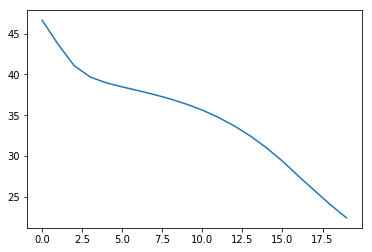

In [103]:
plt.plot(cum_loss)

In [518]:
#refactoring again to track validation loss

def train_model3(model, lr = 1e-3, epochs = 10, loss_func = nn.CrossEntropyLoss(), batch_size = 4):
    optimizer = Adam(model.parameters(), lr = lr)
    running_train_loss = []
    running_valid_loss = []
    for epoch_num in range(epochs):
        start_time = time.time()
        model.train()
        train_loss = 0
        for step_num, batch_data in enumerate(trainloader):
        
            cont_var, subj_notes, medhx, cat_var, labels = tuple(t.to(device) for t in batch_data)
        
            optimizer.zero_grad()
        
            logits = model(cont_var, subj_notes, medhx, cat_var)
        
            batch_loss = loss_func(logits, labels)
        
            train_loss += batch_loss.item()
        
            batch_loss.backward()
        

            clip_grad_norm_(parameters=model.parameters(), max_norm=1.0)
        
            optimizer.step()
        
        #check against validation set
        model.eval()
        valid_loss = 0
        for batch_data in validloader:
            
            cont_var, subj_notes, medhx, cat_var, labels = tuple(t.to(device) for t in batch_data)
            
            logits = model(cont_var, subj_notes, medhx, cat_var)
        
            batch_loss = loss_func(logits, labels)
        
            valid_loss += batch_loss.item()
            
        end_time = time.time()
        print('Epoch {}:'.format(epoch_num + 1),' {0:.3f} sec'.format(end_time - start_time))
        #print("\r" + "{0}/{1} loss: {2} ".format(step_num, len(train_data) / batch_size, train_loss / (step_num + 1)))
        print ('Training loss = {0:.4f}'.format(train_loss/len(trainloader)))
        print ('Validation loss = {0:.4f}'.format(valid_loss/len(validloader)))
        print ()
        
        running_train_loss.append(train_loss/len(trainloader))
        running_valid_loss.append(valid_loss/len(validloader))
        

    return running_train_loss, running_valid_loss

In [163]:
net = Net2(emb_szs)
tloss, vloss = train_model3(net, lr = 1e-4,epochs = 25)

Epoch 1:  0.107 sec
Training loss = 1.3719
Validation loss = 1.3315

Epoch 2:  0.066 sec
Training loss = 1.3510
Validation loss = 1.3285

Epoch 3:  0.062 sec
Training loss = 1.3341
Validation loss = 1.3213

Epoch 4:  0.083 sec
Training loss = 1.3198
Validation loss = 1.3147

Epoch 5:  0.100 sec
Training loss = 1.3061
Validation loss = 1.3076

Epoch 6:  0.086 sec
Training loss = 1.2935
Validation loss = 1.3032

Epoch 7:  0.077 sec
Training loss = 1.2821
Validation loss = 1.2994

Epoch 8:  0.065 sec
Training loss = 1.2709
Validation loss = 1.2939

Epoch 9:  0.074 sec
Training loss = 1.2605
Validation loss = 1.2914

Epoch 10:  0.065 sec
Training loss = 1.2503
Validation loss = 1.2873

Epoch 11:  0.084 sec
Training loss = 1.2408
Validation loss = 1.2871

Epoch 12:  0.074 sec
Training loss = 1.2318
Validation loss = 1.2866

Epoch 13:  0.096 sec
Training loss = 1.2231
Validation loss = 1.2836

Epoch 14:  0.087 sec
Training loss = 1.2145
Validation loss = 1.2794

Epoch 15:  0.074 sec
Training

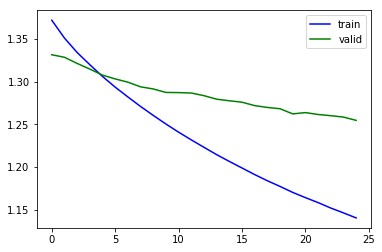

In [164]:
plt.plot(tloss,'b', label = 'train')
plt.plot(vloss,'g', label = 'valid')
plt.legend()
plt.show()

### next step is to complete the pipeline from pandas dataframe

#### but first I have to make the dataframe I want

In [165]:
import os
os.getcwd()

'/Users/jjaskolkambp/Desktop/machine learning/my_projects/ed-triage'

In [170]:
data_path = '/Users/jjaskolkambp/Desktop/machine learning/my_projects/data/ed triage project/egh'

In [173]:
df1 = pd.read_csv(data_path + '/pmhx_embeds.csv', header = None, index_col = 0)
df2 = pd.read_csv(data_path + '/subjnote_embeds.csv', header = None, index_col = 0)
balanced_data = pd.read_csv(data_path + '/balanced_4cls_nlp_data.csv', index_col = 0)

In [176]:
del df1.index.name
del df2.index.name

In [180]:
df1.head()

,1
511,[-5.62175699e-02 -1.55288264e-01 -3.55031192e-...
754,[-2.32482120e-01 -3.98706704e-01 5.75849652e-...
755,[ 7.09933490e-02 -1.90701023e-01 -3.40518981e-...
757,[-6.41224608e-02 1.80907622e-02 -2.60267198e-...
758,[-3.08350593e-01 -8.54802653e-02 3.15538704e-...


In [182]:
df1.columns = ['pmhx_embeds']

df2.columns = ['subjnotes_embeds']

In [187]:
df3 = pd.concat([df1,df2 ], axis = 1)

In [188]:
df3.head()

,pmhx_embeds,subjnotes_embeds
511,[-5.62175699e-02 -1.55288264e-01 -3.55031192e-...,[-2.55204886e-01 6.01891279e-02 2.71235794e-...
754,[-2.32482120e-01 -3.98706704e-01 5.75849652e-...,[ 2.34645531e-01 -1.87844783e-01 4.77293253e-...
755,[ 7.09933490e-02 -1.90701023e-01 -3.40518981e-...,[-2.65869528e-01 -1.80039495e-01 3.75602454e-...
757,[-6.41224608e-02 1.80907622e-02 -2.60267198e-...,[-2.00648651e-01 -2.00332478e-01 3.26978832e-...
758,[-3.08350593e-01 -8.54802653e-02 3.15538704e-...,[-9.09422189e-02 -1.58347234e-01 4.89432931e-...


In [191]:
overlap = [x for x in  df3.index if x in balanced_data.index]

In [192]:
len(overlap)

400

In [193]:
sorted(overlap) == sorted(list(balanced_data.index))

True

In [194]:
ltd_data = df3.loc[overlap]

In [195]:
len(ltd_data)

400

In [196]:
balanced = pd.concat([balanced_data, ltd_data], axis = 1)

#tweaking so there's a change to put on github

In [197]:
balanced.head()

,ID,ChartNumber,EncounterNumber,TriageLevel,AgeNumber,AgeInYrs,GenderDesc,Triage Date & Time,Reg Date & Time,PIA Date & Time,...,target2,discharge,target3,dispo,target4,ICUvsother,target5,pmhx,pmhx_embeds,subjnotes_embeds
1184,1185,E8443276,EE001185/18,2.0,73,73.0,Male,2018-04-06 10:16:00,2018-04-06 10:20:00,2018-04-06 10:17:00,...,3,admit,0,sadmit,2.0,NaN,0,"bowel obstruction d/t bowel adhesions, htn, afib",[-1.18588388e-01 -3.62613685e-02 1.71774179e-...,[-2.39613533e-01 4.64705452e-02 4.14689839e-...
1620,1621,E3111507,EE001622/18,5.0,82,82.0,Female,2018-04-08 11:17:00,2018-04-08 11:21:00,2018-04-08 11:28:00,...,3,admit,0,sadmit,2.0,NaN,0,"diverticulitis, high bp, high cholesterol, thy...",[-1.94503769e-01 -8.38923976e-02 5.67541644e-...,[-1.24572255e-01 -2.15024259e-02 4.72823471e-...
1713,1714,E8216415,EE001716/18,2.0,49,49.0,Male,2018-04-08 18:47:00,2018-04-08 18:50:00,2018-04-08 18:50:00,...,2,admit,0,madmit,1.0,NaN,0,liver and kidney failure,[-6.44557178e-02 2.12498493e-02 -4.99889851e-...,[-6.32119700e-02 -1.49392709e-01 4.46838409e-...
1836,1837,E8152804,EE001838/18,2.0,57,57.0,Male,2018-04-09 10:59:00,2018-04-09 11:02:00,2018-04-09 11:10:00,...,3,admit,0,sadmit,2.0,NaN,0,"htn, diabetic, thyroid, rt total nephrectomy, ...",[-1.45752514e-02 -3.72009605e-01 2.15191156e-...,[-1.14206485e-01 -3.34909745e-02 3.48307520e-...
1837,1838,E8181432,EE001839/18,2.0,75,75.0,Male,2018-04-09 11:11:00,2018-04-09 11:15:00,2018-04-09 11:16:00,...,3,admit,0,sadmit,2.0,NaN,0,no significant medical history,[-6.41224608e-02 1.80907622e-02 -2.60267198e-...,[-1.96476385e-01 -1.18435726e-01 5.01800537e-...


In [200]:
balanced.shape

(400, 48)

In [199]:
balanced.to_csv(data_path +'/total_balanced_dataset.csv')

#### now that I have the "balanced" dataframe, I can build the pipeline

In [201]:
balanced.shape

(400, 48)

In [859]:
balanced.columns

Index(['ID', 'ChartNumber', 'EncounterNumber', 'TriageLevel', 'AgeNumber',
       'AgeInYrs', 'GenderDesc', 'Triage Date & Time', 'Reg Date & Time',
       'PIA Date & Time', 'Disposition Date & Time', 'DischargeDisposition',
       'DischargeDispositionDesc', 'Left ED Date & Time',
       'PresentingComplaint', 'PresentingComplaintDesc', 'MainDiagnosisCode',
       'MainDiagnosisCodeDesc', 'AdmitLocation', 'PatientService',
       'SubjectiveNotes', 'InfectionControlScreening', 'MedicalHistory',
       'BloodPressure_LastEDReading', 'O2Saturation_LastEDReading',
       'Pulse_LastEDReading', 'Temperature_LastEDReading', 'o2sat', 'pulse',
       'temp', 'CleanSubjectiveNotes', 'BP', 'systolic', 'diastolic', 'Gender',
       'outcome', 'target', 'service', 'target2', 'discharge', 'target3',
       'dispo', 'target4', 'ICUvsother', 'target5', 'pmhx', 'pmhx_embeds',
       'subjnotes_embeds', 'AgeInYrs_norm', 'o2sat_norm', 'temp_norm',
       'pulse_norm', 'systolic_norm', 'diastolic_norm

In [613]:
#turning the embedding columns into arrays along the lines of what I created bedore

subj = np.array([s[1:-1].split() for s in list(balanced.subjnotes_embeds)]).astype(np.float32)
medhx = np.array([s[1:-1].split() for s in list(balanced.pmhx_embeds)]).astype(np.float32)

In [614]:
subj.dtype, medhx.dtype

(dtype('float32'), dtype('float32'))

In [619]:
#each of these will start as a list of relevant columns and be handled differently
cont_vars = ['AgeInYrs', 'o2sat', 'temp', 'pulse', 'systolic', 'diastolic']
cat_vars = ['TriageLevel', 'Gender', 'PresentingComplaint']

In [620]:
#making the labels
labels = balanced.target2.values - 1

In [621]:
def normalize(df, columns):
        print (columns)
        "Compute the means and stds of `self.cont_names` columns to normalize them."
        new_cols = []
        for n in columns:
            df[n + '_norm'] = (df[n]-df[n].mean()) / (1e-7 + df[n].std())
            new_cols.append(n+ '_norm')
            
            
        for n in new_cols:
            if pd.isnull(df[n]).sum():
                filler = df[n].median()
                df[n] = df[n].fillna(filler)
        return new_cols

In [622]:
new_cols = normalize(balanced, cont_vars)

['AgeInYrs', 'o2sat', 'temp', 'pulse', 'systolic', 'diastolic']


In [623]:
balanced.head()

,ID,ChartNumber,EncounterNumber,TriageLevel,AgeNumber,AgeInYrs,GenderDesc,Triage Date & Time,Reg Date & Time,PIA Date & Time,...,target5,pmhx,pmhx_embeds,subjnotes_embeds,AgeInYrs_norm,o2sat_norm,temp_norm,pulse_norm,systolic_norm,diastolic_norm
1184,1185,E8443276,EE001185/18,2.0,73,73.0,Male,2018-04-06 10:16:00,2018-04-06 10:20:00,2018-04-06 10:17:00,...,0,"bowel obstruction d/t bowel adhesions, htn, afib",[-1.18588388e-01 -3.62613685e-02 1.71774179e-...,[-2.39613533e-01 4.64705452e-02 4.14689839e-...,0.797240,0.301261,-0.180775,-0.841688,0.573110,0.286222
1620,1621,E3111507,EE001622/18,5.0,82,82.0,Female,2018-04-08 11:17:00,2018-04-08 11:21:00,2018-04-08 11:28:00,...,0,"diverticulitis, high bp, high cholesterol, thy...",[-1.94503769e-01 -8.38923976e-02 5.67541644e-...,[-1.24572255e-01 -2.15024259e-02 4.72823471e-...,1.174497,0.826922,-1.263975,-1.384923,-0.264089,-0.016198
1713,1714,E8216415,EE001716/18,2.0,49,49.0,Male,2018-04-08 18:47:00,2018-04-08 18:50:00,2018-04-08 18:50:00,...,0,liver and kidney failure,[-6.44557178e-02 2.12498493e-02 -4.99889851e-...,[-6.32119700e-02 -1.49392709e-01 4.46838409e-...,-0.208779,-1.538556,-0.180775,0.516400,-1.021555,-0.456082
1836,1837,E8152804,EE001838/18,2.0,57,57.0,Male,2018-04-09 10:59:00,2018-04-09 11:02:00,2018-04-09 11:10:00,...,0,"htn, diabetic, thyroid, rt total nephrectomy, ...",[-1.45752514e-02 -3.72009605e-01 2.15191156e-...,[-1.14206485e-01 -3.34909745e-02 3.48307520e-...,0.126560,0.564091,0.767024,1.104905,-0.343823,-0.126169
1837,1838,E8181432,EE001839/18,2.0,75,75.0,Male,2018-04-09 11:11:00,2018-04-09 11:15:00,2018-04-09 11:16:00,...,0,no significant medical history,[-6.41224608e-02 1.80907622e-02 -2.60267198e-...,[-1.96476385e-01 -1.18435726e-01 5.01800537e-...,0.881075,-0.487232,0.090025,-1.430192,-0.104623,-0.126169


In [627]:
cont = np.array(balanced[new_cols]).astype(np.float32)

In [628]:
cont.shape

(400, 6)

In [630]:
class_lengths = [len(set(balanced[cat])) for cat in cat_vars]
class_lengths

[5, 2, 69]

In [631]:
numerical_cat_data = []
for cat in cat_vars:
    #first make a dictionary mapping original name to a number
    cat_to_num  = {cat:i for i,cat in enumerate(list(set(balanced[cat])))}
    #then replace the categorgal label with numbers and add to output list
    numerical_cat_data.append([cat_to_num[item] for item in balanced[cat]])

In [632]:
#this makes a vertical array out of the categorical data
cats_array = np.vstack(np.array(numerical_cat_data).astype(int)).transpose(); cats_array.shape

(400, 3)

In [633]:
#creating a set of embedding sizes for each categorical variable
emb_szs = [(length, min(600, round(1.6 * length **0.56))) for length in class_lengths]
emb_szs

[(5, 4), (2, 2), (69, 17)]

In [642]:
train_subj, validation_subj = train_test_split(subj, random_state = 42, test_size=0.1)
train_medhx, validation_medhx = train_test_split(medhx, random_state = 42, test_size=0.1)
train_cont, validation_cont = train_test_split(cont, random_state = 42, test_size=0.1)
train_cats, validation_cats = train_test_split(cats_array, random_state = 42, test_size=0.1)
train_labels, validation_labels = train_test_split(labels, random_state = 42, test_size=0.1)

In [643]:
train_subj = torch.tensor(train_subj)
validation_subj = torch.tensor(validation_subj)
train_medhx = torch.tensor(train_medhx)
validation_medhx = torch.tensor(validation_medhx)
train_cont = torch.tensor(train_cont)
validation_cont = torch.tensor(validation_cont)
train_cats = torch.tensor(train_cats)
validation_cats = torch.tensor(validation_cats)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)

In [724]:
batch_size = 4

train_data = TensorDataset(train_subj, train_medhx, train_cont,train_cats,train_labels)
trainloader = DataLoader(train_data, batch_size=batch_size, shuffle = True)

valid_data = TensorDataset(validation_subj, validation_medhx, validation_cont, validation_cats, validation_labels)
validloader = DataLoader(valid_data, batch_size=batch_size, shuffle = True)

In [867]:
class Net3(nn.Module):
    def __init__(self, emb_szs):
        super(Net3, self).__init__()
        
        #first create the embedding layers for each of the categorical variables
        self.embed_layers = nn.ModuleList([nn.Embedding(ni, nf) for ni,nf in emb_szs])
        n_emb = sum(e.embedding_dim for e in self.embed_layers)
        
        #define dropouts
        self.emb_drop = nn.Dropout(0.5)
        self.lin_drop = nn.Dropout(0.5)
        
        #define batchnorms
        self.nlp1_bn = nn.BatchNorm1d(768)
        self.nlp2_bn = nn.BatchNorm1d(768)
        self.comb_bn = nn.BatchNorm1d(36)
        self.comb_bn2 = nn.BatchNorm1d(200)
        
        self.linear_subjective = nn.Linear(768,10)  
        self.linear_medhx = nn.Linear(768, 10)
        self.linear_cat = nn.Linear(n_emb,10)
        self.linear_combined1 = nn.Linear(36, 200)
        self.linear_combined2 = nn.Linear(200,100)
        self.out = nn.Linear(100,4)

    def forward(self, subj,medhx,cont,cat_var):
        #first we run each BERT vector through a linear layer and activation
        nlp1 = F.relu(self.linear_subjective(self.lin_drop(subj)))
        nlp2 = F.relu(self.linear_medhx(self.lin_drop(medhx)))
        
        #now we pass each categorical variable through an embedding layer, combine output and pass through
        #a linear layer with activation
        embeds = [e(cat_var[:,i]) for i,e in enumerate(self.embed_layers)]
        embeds = torch.cat(embeds, 1)
        embeds = self.linear_cat(embeds)
        embeds = self.emb_drop(embeds)
        #embeds = F.relu(self.linear_cat(embeds))  #they dont have an activation after the embeddings in fast.ai
        
        #now we combine all four sources of input and pass through a layer with activation
        combined = torch.cat((nlp1,nlp2,cont,embeds), axis = 1)
        combined_norm = self.lin_drop(self.comb_bn(combined))
        x = F.relu(self.linear_combined1(combined_norm))
        x = F.relu(self.linear_combined2(self.lin_drop(self.comb_bn2(x))))
        
        #compute logits
        x = self.out(x)
        
        return x





In [868]:
net = Net3(emb_szs)
net

Net3(
  (embed_layers): ModuleList(
    (0): Embedding(5, 4)
    (1): Embedding(2, 2)
    (2): Embedding(69, 17)
  )
  (emb_drop): Dropout(p=0.5, inplace=False)
  (lin_drop): Dropout(p=0.5, inplace=False)
  (nlp1_bn): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (nlp2_bn): BatchNorm1d(768, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (comb_bn): BatchNorm1d(36, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (comb_bn2): BatchNorm1d(200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear_subjective): Linear(in_features=768, out_features=10, bias=True)
  (linear_medhx): Linear(in_features=768, out_features=10, bias=True)
  (linear_cat): Linear(in_features=23, out_features=10, bias=True)
  (linear_combined1): Linear(in_features=36, out_features=200, bias=True)
  (linear_combined2): Linear(in_features=200, out_features=100, bias=True)
  (out): Linear(in_features=100, out_features=4, bias=True

In [869]:
x1,x2,x3,x4,x5 = next(iter(trainloader))

In [870]:
net(x1,x2,x3,x4)

tensor([[-0.4133, -0.0332, -0.4821,  0.3188],
        [-0.4989, -0.0729,  0.3424, -0.5555],
        [-0.2026,  0.6119, -0.2030, -0.4365],
        [-0.1506,  0.2384, -0.5336, -0.3117]], grad_fn=<AddmmBackward>)

In [871]:
net = Net3(emb_szs)
tloss, vloss = train_model3(net, lr = 1e-3,epochs = 50)

Epoch 1:  0.467 sec
Training loss = 1.3977
Validation loss = 1.3572

Epoch 2:  0.476 sec
Training loss = 1.3244
Validation loss = 1.4125

Epoch 3:  0.443 sec
Training loss = 1.3577
Validation loss = 1.3353

Epoch 4:  0.445 sec
Training loss = 1.3845
Validation loss = 1.2872

Epoch 5:  0.441 sec
Training loss = 1.3467
Validation loss = 1.3325

Epoch 6:  0.450 sec
Training loss = 1.3024
Validation loss = 1.3217

Epoch 7:  0.488 sec
Training loss = 1.3461
Validation loss = 1.3372

Epoch 8:  0.448 sec
Training loss = 1.3148
Validation loss = 1.3448

Epoch 9:  0.447 sec
Training loss = 1.3299
Validation loss = 1.4178

Epoch 10:  0.482 sec
Training loss = 1.3200
Validation loss = 1.4277

Epoch 11:  0.476 sec
Training loss = 1.3020
Validation loss = 1.3817

Epoch 12:  0.478 sec
Training loss = 1.2925
Validation loss = 1.3332

Epoch 13:  0.588 sec
Training loss = 1.3147
Validation loss = 1.2378

Epoch 14:  0.471 sec
Training loss = 1.2555
Validation loss = 1.2823

Epoch 15:  0.487 sec
Training

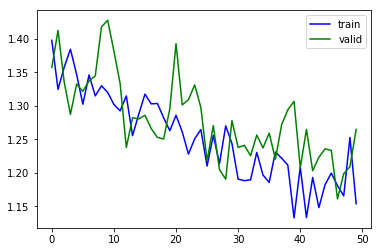

In [872]:
plt.plot(tloss,'b', label = 'train')
plt.plot(vloss,'g', label = 'valid')
plt.legend()
plt.show()

In [873]:
#let's do some inference
net.eval()
pred_matrix = []
label_matrix = []

for batch_data in validloader:
            
    cont_var, subj_notes, medhx, cat_var, labels = tuple(t.to(device) for t in batch_data)
            
    logits = net(cont_var, subj_notes, medhx, cat_var)
        
    preds = np.argmax(logits.detach().numpy(), axis = 1)
    pred_matrix.append(preds)
    
    labels = labels.detach().numpy()
    label_matrix.append(labels)

y_pred = [item for sublist in pred_matrix for item in sublist]
y_true = [item for sublist in label_matrix for item in sublist]

classification = metrics.classification_report(y_pred,y_true, target_names = ['discharge', 'madmit', 'sadmit', 'ICU'])
conf = metrics.confusion_matrix(y_pred,y_true)
acc = metrics.accuracy_score(y_pred,y_true)
print ('Classification Report:')
print(classification)
print ()
print('Confusion Matrix:')
print (conf)
print()
print ('accuracy = ', acc *100, '%')

Classification Report:
             precision    recall  f1-score   support

  discharge       0.36      0.44      0.40         9
     madmit       0.21      0.75      0.33         4
     sadmit       1.00      0.38      0.55        16
        ICU       0.67      0.55      0.60        11

avg / total       0.69      0.47      0.51        40


Confusion Matrix:
[[4 4 0 1]
 [0 3 0 1]
 [6 3 6 1]
 [1 4 0 6]]

accuracy =  47.5 %


for the most part, the best I can do with this model is 47.5% accuracy. 

next step will be to add the comorbid column.  will need to reembed the cleaned versions of the notes and medhx